In [1]:
import rasterio
import rasterio.plot
import numpy as np
from osgeo import gdal_array
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter
from scipy.interpolate import pchip_interpolate, InterpolatedUnivariateSpline
import math
from scipy.optimize import minimize
import ad
import tqdm #进度条
import matplotlib.pyplot as plt
%matplotlib inline


# 滤波

## 输入数据要求
- **时间序列影像**：`GeoTiff` 格式的时间序列影像（`*.tif`），其中每个波段表示不同日期的 NDVI 影像，第一个波段为这年第001天的影像，第二个波段为第017天的影像，以此类推。

【注意】为了减小文件大小，输入的NDVI值被乘以$10000$，然后以`Int 16`整形存储。如果需要获得真实NDVI需要乘以比例系数$0.00001$. 比例系数不会影响物候期提取，可以不乘。

## 输出数据格式
- **SG滤波后的时间序列影像**：`GeoTiff` 格式的时间序列影像（`*.tif`），格式与输入数据要求一致，输出的文件名为 `<年份>.tif`，其中`<年份>`为影像的年份，格式如：2019, 2018等等。

### 注意
1. 由于影像文件较大，滤波然后保存文件可能会比较耗时。
2. 在运行此脚本前，请清空所有不必要的内存，否则无法分配内存运算，导致程序异常退出。

In [2]:
# 时间和日期定义
years = range(2019, 2020) # 定义年份
dates = np.arange(1, 365, 16).tolist() # 定义日期，MODIS从每年第一天到365天之间每隔16天一景
dates[1:20]

for year in years:
    raw_img_path = "data/" + str(year) + '.tif'
    out_img_path = "data/" + str(year) + '_filtered.tif'
    raw_img = gdal_array.LoadFile(raw_img_path)
    src = rasterio.open("data/" + str(year) + '.tif')
    [doy, img_ht, img_wd] = raw_img.shape
    filtered_img = np.zeros((doy, img_ht, img_wd))
    
    # SG滤波，参数可调整
    for x in range(1,img_ht):
        # 打印进度信息，因为SG滤波耗时较长。
        if x%100 == 0:
            print(x, ' of ', img_ht, '\t', x/img_ht *100, '%')
        for y in range(1,img_wd):
            series = raw_img[:,x,y] # 获取原始影像时间序列
            if np.count_nonzero(series) > 20:
                filtered_series = savgol_filter(series, 5, 3) # SG滤波
                filtered_img[:,x,y] = filtered_series # 滤波后存储到新影像中
            else:
                continue
   
    # 把滤波后的时间序列存储到新的影像中
    with rasterio.open(
        out_img_path,
        'w',
        driver='GTiff',
        height=filtered_img.shape[1],
        width=filtered_img.shape[2],
        count=filtered_img.shape[0],
        dtype=rasterio.int16, #存储数据精度为 Int16
        crs=src.crs,
        transform=src.transform,
    ) as dst:
        dst.write(filtered_img) 

    
plt.imshow(filtered_img[10,:,:])
print(filtered_img.shape)

100  of  6359 	 1.5725743041358704 %
200  of  6359 	 3.145148608271741 %
300  of  6359 	 4.717722912407611 %
400  of  6359 	 6.290297216543482 %
500  of  6359 	 7.862871520679351 %
600  of  6359 	 9.435445824815222 %
700  of  6359 	 11.008020128951093 %
800  of  6359 	 12.580594433086963 %
900  of  6359 	 14.153168737222835 %
1000  of  6359 	 15.725743041358703 %
1100  of  6359 	 17.298317345494574 %
1200  of  6359 	 18.870891649630444 %
1300  of  6359 	 20.443465953766314 %
1400  of  6359 	 22.016040257902187 %
1500  of  6359 	 23.588614562038057 %
1600  of  6359 	 25.161188866173926 %
1700  of  6359 	 26.7337631703098 %
1800  of  6359 	 28.30633747444567 %
1900  of  6359 	 29.87891177858154 %
2000  of  6359 	 31.451486082717405 %
2100  of  6359 	 33.02406038685328 %
2200  of  6359 	 34.59663469098915 %
2300  of  6359 	 36.16920899512502 %
2400  of  6359 	 37.74178329926089 %
2500  of  6359 	 39.31435760339676 %
2600  of  6359 	 40.88693190753263 %
2700  of  6359 	 42.459506211668504 

ValueError: the array's dtype 'float64' does not match the file's dtype 'int16'

In [4]:
with rasterio.open(
    out_img_path,
    'w',
    driver='GTiff',
    height=filtered_img.shape[1],
    width=filtered_img.shape[2],
    count=filtered_img.shape[0],
    dtype=rasterio.float64, #存储数据精度为 Int16
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(filtered_img) 

In [12]:
filtered_img_int = filtered_img.astype(np.int16)

In [13]:
with rasterio.open(
    "data/" + str(year) + '_filtered_int.tif',
    'w',
    driver='GTiff',
    height=filtered_img_int.shape[1],
    width=filtered_img_int.shape[2],
    count=filtered_img_int.shape[0],
    dtype=rasterio.int16, #存储数据精度为 Int16
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(filtered_img_int) 

# Phenology

## Double logistic regression

Source: [Github](https://raw.githubusercontent.com/tquaife/phenology/master/fitPhenology.py)

In [ ]:
def double_logistic_array(params,timeArr):
    phenology=[]
    for time in timeArr:
        phenology.append(double_logistic(params,time))
    return np.array(phenology)

def double_logistic(params,time):
    """Generate a double logistic curve similar 
    to those of the MODIS phenology product
    
    k1   --- curvature parmeter for first half of season
    k2   --- curvature parmeter for second half of season
    t01  --- timing parmeter for first half of season
    t02  --- timing parmeter for second half of season
    c    --- minimum LAI/NDVI etc
    d    --- maximum LAI/NDVI etc
    
    time --- time valueto evaluate the function 
    """
    k1  =params[0]
    k2  =params[1]
    t01 =params[2]
    t02 =params[3]
    c   =params[4]
    d   =params[5]
    lgstc1=(c-d)/(1.+math.exp(k1*(time-t01)))+d    
    lgstc2=(d-c)/(1.+math.exp(k2*(time-t02)))+c
    return np.min([lgstc1,lgstc2])
    
def genSynthObs(params,freq=16,stddev=0.3,cloud=0.0):
    
    time_arr=[]
    synth_obs=[]
    for t in range(1,365,freq):
        if np.random.rand()<cloud:
            continue
        time_arr.append(t)
        obs=double_logistic(params,t)
        obs=obs+np.random.normal(0.,stddev)
        synth_obs.append(obs)
        
    return np.array(synth_obs),np.array(time_arr)


def rmse(params,obs,obs_time):
    model=double_logistic_array(params,obs_time)
    return np.sqrt(np.sum((model-obs)**2)/float(len(obs_time)))
    
def solver(params,obs,obs_time,costFunction):
    costGradient, costHessian=ad.gh(costFunction)
    return minimize(costFunction,\
                    params,\
                    args=(obs,obs_time),\
                    method='L-BFGS-B',\
                    jac=costGradient,\
                    options={'gtol': 1e-10})
    
    
    
if __name__=="__main__":
    

    filtered_img_path = '/home/dk/文档/李明/Code/data/2001_filtered.tif'
    filtered_img = gdal_array.LoadFile(raw_img_path)
    
    test_series = np.ndarray.transpose(filtered_img[:,60,35])

    time_arr=np.arange(1, 365, 16)
    
    params=np.zeros(6)
    params[0]=0.2
    params[1]=0.4
    params[2]=170
    params[3]=270
    params[4]=0.1
    params[5]=0.2
    
    phenology=double_logistic_array(params,time_arr)
    #synth_obs, obs_times=genSynthObs(params,freq=16,stddev=0.25,cloud=0)
    
    synth_obs = test_series / 10000
    obs_times = time_arr
    
    #print(obs_times)
      
    s=solver(params,synth_obs,obs_times,rmse)
    
    print(obs_times.shape)
    print(test_series.shape)
  
    retrieval=double_logistic_array(s.x,time_arr)
    #plt.plot(obs_times, test_series / 10000, label="test")
    
    
    plt.plot(time_arr,phenology, label="truth")
    
    plt.plot(obs_times,synth_obs,"o", label="obs")
    plt.plot(time_arr,retrieval, label="retrieved")

    plt.xlabel("Day of year")
    plt.ylabel("NDVI (-)")
    #plt.ylim([0,3.0])
    plt.legend()
    #plt.show()
    plt.savefig("phenology_example.png")


## Fit with harmonic model

Fit Modis NDVI series with harmonic model:

$y = a \cdot \sin(b \cdot x) + c \cdot \cos(d \cdot x) + e \cdot x + f $

$y$: NDVI,

$x$: DOY(day of year)

see [curve fitting](https://scipy-lectures.org/intro/scipy/auto_examples/plot_curve_fit.html)

### Experiment for a single pixel and visualization

In [279]:
from scipy import optimize

filtered_img_path = '/home/dk/文档/李明/Code/data/2001_filtered.tif'
filtered_img = gdal_array.LoadFile(filtered_img_path)

dates = np.arange(1.0, 366, 16)

series = np.ndarray.transpose(filtered_img[:,60,60] / 10000)


def test_func(x, a, b, c, d, e, f, g):
    return a * np.sin(b * x) + c * np.cos(d * x) + e * x**2 + f * x + g
    # return a * np.sin(b * x) + c * np.cos(d * x) + f * x + g

def double_logistic_array(params,timeArr):
    phenology=[]
    for time in timeArr:
        phenology.append(double_logistic(time, params))
    return np.array(phenology)
    
def double_logistic(time, a, b, c, d, e, f):
    """Generate a double logistic curve similar 
    to those of the MODIS phenology product
    
    k1   --- curvature parmeter for first half of season
    k2   --- curvature parmeter for second half of season
    t01  --- timing parmeter for first half of season
    t02  --- timing parmeter for second half of season
    c    --- minimum LAI/NDVI etc
    d    --- maximum LAI/NDVI etc
    
    time --- time valueto evaluate the function 
    """
    k1  = a
    k2  = b
    t01 = c
    t02 = d
    c   = e
    d   = f
    lgstc1=(c-d)/(1.+math.exp(k1*(time-t01)))+d    
    lgstc2=(d-c)/(1.+math.exp(k2*(time-t02)))+c
    return np.min([lgstc1,lgstc2])

    
params, params_covariance = optimize.curve_fit(double_logistic, dates, series,
                                               p0=[0,0,0,0,0,0])


plt.plot(dates,series,"o", label="observed")
#plt.plot(dates,fit, label="fit")
plt.plot(dates, test_func(dates, params[0], params[1], params[2], params[3], params[4], params[5]),
         label='Fitted function')

plt.xlabel("Day of year")
plt.ylabel("NDVI (-)")
plt.ylim([0,0.5])
plt.legend()
plt.show()
#plt.savefig("phenology_example.png")

TypeError: only size-1 arrays can be converted to Python scalars

### Running on rasters 

(20, 128, 115)


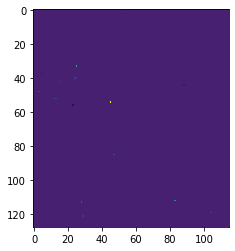

In [5]:
from scipy import optimize

years = [2000]
dates = np.arange(1, 315, 16) #.tolist()

def test_func(x, a,b,c,d,e,f,g):
    return a * np.sin(b * x) + c * np.cos(d * x) + e * x**2 + f * x + g

for year in years:
    filtered_img_path = "data/" + str(year) + '_filtered.tif'
    out_img_path = "data/fitted/" + str(year) + '_fitted.tif'
    raw_img = gdal_array.LoadFile(filtered_img_path)
    src = rasterio.open("data/" + str(year) + '.tif')
    [num_dates, img_ht, img_wd] = raw_img.shape
    filtered_img = np.zeros((num_dates, img_ht, img_wd))
    for x in range(1,img_ht):
        for y in range(1,img_wd):
            series = raw_img[:,x,y]
            params, params_covariance = optimize.curve_fit(test_func, dates, series,
                                                           p0=[0,2,0,2,-4,0,2],
                                                           maxfev=35000000)
            filtered_img[:,x,y] = test_func(dates, params[0], params[1], params[2], 
                                            params[3], params[4], params[5], params[0])
   
    with rasterio.open(
        out_img_path,
        'w',
        driver='GTiff',
        height=filtered_img.shape[1],
        width=filtered_img.shape[2],
        count=filtered_img.shape[0],
        dtype=rasterio.float64,
        crs=src.crs,
        transform=src.transform,
    ) as dst:
        dst.write(filtered_img) 

    
plt.imshow(filtered_img[10,:,:])
print(filtered_img.shape)

In [278]:
dates

array([  1.,  17.,  33.,  49.,  65.,  81.,  97., 113., 129., 145., 161.,
       177., 193., 209., 225., 241., 257., 273., 289., 305., 321., 337.,
       353.])